In [1]:
from mtree import MTree
import numpy as np
import matplotlib.pyplot as plt
import random

plt.style.use('default')
colors = ['tab:red', 'tab:purple', 'tab:blue', 'tab:green', 'tab:orange', 'tab:pink', 'tab:cyan']

# MTree

## Intro

Similar to a B-Tree (self-balancing sorted) that generalizes the binary search tree, allowing for nodes with more than two children. Unlike other self-balancing binary search trees, the B-tree is well suited for storage systems that read and write relatively large blocks of data, such as databases and file systems.

It is constructed using a **metric** and relies on the **triangle inequality** for efficient range and k-nearest neighbor (k-NN) queries.

## Description

A metric space is a pair $(M, d)$ where $M$ is a set of values and $d: M \times M \to \mathbb{R}^+$ is a distance function that satisfies the following axioms, considering $a, b, c \in M$:
1. $d(a, b) = d(b, a)$
1. $d(a, b) = 0$ iff $a = b$
2. (*Desigualdade Triangular*) $d(a, c) \le d(a, b) + d(b, c)$

*Example*: $M = \mathbb{R}^n$ and $d = L^p$, where the $L^p$-norm is given by
$$\|\mathbf{x}\|_p := \left(\sum_{i = 1}^n |x_i|^p\right)^{1/p}$$

For $p=1$, we have the Manhattan (Taxicab) norm, for $p=2$ the Euclidean norm, and in the limit, as $p \to \infty$, the Chebyshev norm.

The operations of interest in this tree are:
- Range Search
- KNN 

## Structure

All the data is in the leaves. The internal nodes store auxiliary objects for routing the search, denoted by $O_r$.

## Range Search

<img src="imgs/mtree_prunecond.png" style="width: 50%">

**Lemma** If $d(O_r, Q) > R + r(O_r)$, then for any object $O_j$ in the subtree $T(O_r)$, $d(O_j, Q) > R$ and therefore, $T(O_r)$ can be pruned.

**Pf.** From the triangle inequality, $d(O_r, Q) \le d(O_r, O_j) + d(O_j, Q) \Leftrightarrow d(O_j, Q) \ge d(O_r, Q) - d(O_j, O_r)$

From the definition of the radius, $d(O_j, O_r) \le r(O_r)$

From the previous results, $d(O_j, Q) \ge d(O_r, Q) - r(O_r)$

From the hypothesis, $d(O_r, Q) > R + r(O_r)$, thus

$$d(O_j, Q) \ge d(O_r, Q) - r(O_r) > \left(R + r(O_r)\right) - r(O_r) = R$$

---
RangeSearch($N$, $Q$, $R$)
1. if $N$ is leaf
2. &emsp; for $O_j$ in $N$
3. &emsp;&emsp; if $d(O_j, Q) \le R$
4. &emsp;&emsp;&emsp; add($O_j$)
5. else
6. &emsp; for $O_r$ in $N$
7. &emsp;&emsp; if $d(O_r, Q) \le R + r(O_r)$
8. &emsp;&emsp;&emsp; RS($T(O_r)$, $Q$, $R$)
---

To save on distance calculations, $d(O_r, Q)$ and $d(O_j, Q)$, the following lemma can be used:

**Lemma** If $|d(Q, O_p) - d(O_p, O_r)| > R + r(O_r)$, then $d(O_r, Q) > R + r(O_r)$

**Pf.** Application of the reverse triangle inequality $d(a, b) \ge |d(a, c) - d(b, c)|$

Considering that $d(Q, O_p)$ was previously calculated and $d(O_p, O_r)$ is known.

## k-NN Search

O resultado vai ser colocado em um array de tamanho $k$ cuja entrada $NN[i]$ é o $i$-esimo vizinho mais próximo com distancia $d_i$. A lista $NN$ é dinamica, mas o resultado correto estara presente nela quando terminar. Ela é inicializada com todos elementos indefinidos e distancias infinitas $[\emptyset,\infty]$

Para esse algoritmo, sera util definir dois limitantes:

(Limitante Inferior) A menor distancia entre os elementos de uma sub-arvore $T(O_r)$ e uma query $Q$.
$$d_\text{min}(O_r) = \max\{0, d(O_r, Q) - r(O_r)\}$$
Sendo que $d_\text{min}$ eh zero quando $Q$ esta dentro do circulo definido por $O_r$.

<img src="imgs/mtree_knndmin.png" style="width: 30%">

(Limitante Superior) A maior distancia entre um elemento de uma sub-arvore e uma query.
$$d_\text{max}(O_r) = d(O_r, Q) + r(O_r)$$

Em particular, sao usados para podar a arvore e como criterio de selecao de uma Priority Queue (PQ) na qual a busca eh dada por:

---
ChooseNode(PR)
1. Retorne a sub-arvore $T(O_r^\ast)$ com menor $d_\text{min}(O_r^\ast)$ da PR
---

Pq esse criterio parece ser bom? Uma vez que a sub-arvore mais proxima foi selecionada, eh possivel imaginar que todos os elementos da PQ foram preenchidos com objetos com distancias pequenas. Dessa maneira, o objeto mais distante $NN[k]$ ainda esta perto e a poda pode ser mais efetiva.

(Condicoes de Poda) Ao longo desse algoritmo, a lista $NN$ vai se alterando de forma dinamica. Em particular, um elemento que impacta de forma direta o espaco de busca eh o elemento $NN[k]$, cuja distancia para $Q$ eh dada por $d_k$, pois podemos podar a busca de toda $T(O_r)$ em que $d_\text{min}(O_r) > d_k$ (se a menor distancia do conjunto for maior que meu pior candidato, uma vez que o pior candidato ainda eh melhor que todo esse conjunto).

Por outro lado, se eu tenho $\max_s d_\text{max}(O_{s}) < d_\text{min}(O_{r})$, tambem posso podar $T(O_r)$

---
NodeSearch($N$, $Q$, $k$)
1. if $N$ is leaf
2. &emsp;for $O_j$ in $N$
3. &emsp;&emsp;if $d(O_j, Q) < d_k$ # Existe um novo melhor candidato
4. &emsp;&emsp;&emsp;Adicionar $[O_j, d(O_j, Q)]$ em $NN$ e atualizar $d_k$
5. &emsp;&emsp;&emsp;Podar de PR todo $O_r$ tal que $d_\text{min}(O_r) > d_k$
6. else
7. &emsp;for $O_r$ in $N$
8. &emsp;&emsp;if $d_\text{min}(O_r) \le d_k$ # Pode ter objetos validos
9. &emsp;&emsp;&emsp;PQ.add([$O_r$, $d_\text{min}(O_r)$])
10. &emsp;&emsp;&emsp;if $d_\text{max}(O_r) < d_k$ # Existe um novo melhor candidato
11. &emsp;&emsp;&emsp;&emsp;Adicionar $[\_, d_\text{max}(O_r)]$ em $NN$ e atualizar $d_k$
12. &emsp;&emsp;&emsp;&emsp;Podar de PR todo $O_r$ tal que $d_\text{min}(O_r) > d_k$
---

Quem fica repetindo essa chamada eh a funcao

---
KnnSearch(Root, $Q$, $k$)
1. PR = [Root, _]
2. Inicializa NN[i] = [_, inf]
3. Enquanto PR $\neq \emptyset$
4. &emsp;NextNode=ChooseNode(PR)
5. &emsp;NodeSearch(NextNode, $Q$, $k$)
---

### Variantes

VP-Tree e MVP-Tree (nao balanceadas)

### Downside

While M-trees can perform well in many conditions, the tree can also have large overlap and there is no clear strategy on how to best avoid overlap.

A Distância cosseno dada por
$$d_\text{cos}(\mathbf{z}_i, \mathbf{z}_j) = 1 - \mathbf{z}_i\cdot \mathbf{z}_j$$
não é uma métrica, pois não satisfaz a desigualdade triangular.

Exemplo: $(1, 0), (0, 1), (1/\sqrt{2}, 1/\sqrt{2})$

$$d\left((1, 0), (1/\sqrt{2}, 1/\sqrt{2})\right) + d\left((1/\sqrt{2}, 1/\sqrt{2}), (0, 1)\right) = $$
$$1 - 1/\sqrt{2} + 1 - 1/\sqrt{2} = 2 - \sqrt{2} = 0.58$$

$$d\left((0, 1), (1, 0)\right) = 1 > 0.58\quad (!)$$

A Distância Euclidiana é uma métrica e a sua relação com a distância cosseno é

$$d_\text{L2}(a, b) = \sqrt{(a-b)\cdot(a-b)} = \sqrt{a\cdot a + b\cdot b - 2a\cdot b} = \sqrt{a\cdot a + b\cdot b - 2(1 - d_\text{cos}(a,b))}$$

Considerando vetores unitários 

$$d_\text{L2}(a,b) = (a,b)\sqrt{2 - 2(1 - d_\text{cos}(a,b))} = \sqrt{2 d_\text{cos}(a,b)}$$

Outra opção é a distância angular, mas nesse caso seria necessário calcular a função transcendente $\arccos(\cdot)$

kNN on cosine distance:
- knn with cosine similarity (distance): https://github.com/miladce/knn-cosine-similarity
- A Triangle Inequality for Cosine Similarity: https://www.sisap.org/2021/preprints/03_Schubert.pdf

In [2]:
def plot_vectors(vectors):
    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.grid(True, which='both')
    
    n = len(vectors)
    random.shuffle(colors)
    for i in range(n):
        v = vectors[i]['vector']
        plt.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1, color=colors[i], label=vectors[i]['id'])

    plt.legend()
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Plot of 2D Vectors')

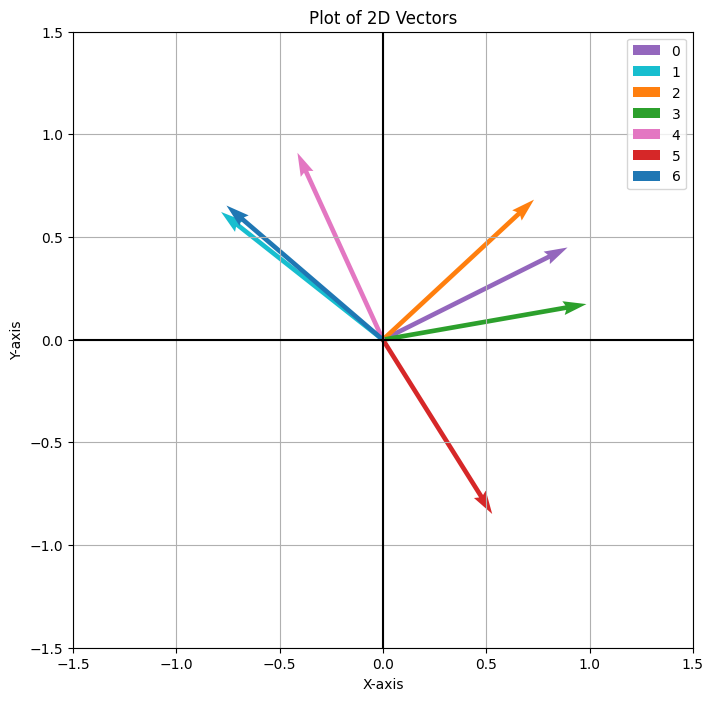

In [3]:
vectors = []
n = 7
for i in range(n):
    v = 2*np.random.rand(2) - 1
    vectors.append({'id': i, 'vector': v/np.linalg.norm(v)})
plot_vectors(vectors)

In [11]:
def dcos(x ,y):
    return 1 - np.dot(x['vector'], y['vector'])

def dL2(x ,y):
    return np.sqrt(2 * dcos(x, y))

def L2(x, y):
    return np.linalg.norm(x['vector'] - y['vector'])

tree = MTree(L2, max_node_size=4)

In [12]:
for i in range(n):
    if i == 6:
        continue
    else:
        tree.add(vectors[i])

#tree.add_all([vectors[i] for i in range(1, 6)])

In [10]:
# k-NN search
k = 3
list(tree.search(vectors[6], k))

[{'id': 1, 'vector': array([-0.78293289,  0.62210617])},
 {'id': 4, 'vector': array([-0.4135366,  0.9104875])},
 None]